In [6]:
import torch
import torchvision.transforms as T
from torchvision.models.vgg import vgg16_bn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Importer ZennitCRP
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.helper import get_layer_names
from crp.concepts import ChannelConcept

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import Isomap
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import hdbscan
from sklearn.cluster import MeanShift
import hdbscan
import umap.umap_ as umap
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score



import math
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = vgg16_bn(True).to(device)
model.eval()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def betterPrintHeatmap(heatmaps):
    #heatmaps = [h.detach().cpu().numpy() for h in heatmaps]
    number_line = math.ceil(len(heatmaps) / 5)
    fig, axes = plt.subplots(number_line, 6, figsize=(18, number_line * 2))

    vmin = min(h.min() for h in heatmaps)
    vmax = max(h.max() for h in heatmaps)
    print(f"Min value for a pixel: {vmin}, Max value for a pixel: {vmax}")
    heatmap_element = 0
    for i, ax in enumerate(axes.flat):
        row, col = divmod(i, 6)
        if heatmap_element >= len(heatmaps):
            ax.axis("off")
            continue
        if col > 4:
            ax.axis("off")
            continue
        im = ax.imshow(heatmaps[heatmap_element], cmap="seismic", interpolation="nearest", vmin=vmin, vmax=vmax)
        ax.set_title(f"Heatmap {heatmap_element+1}")
        heatmap_element += 1


    # Ajouter une barre de couleur verticale à droite de la grille
    fig.colorbar(im, ax=axes, orientation='vertical', location='right')

    # Ajuster l'espacement pour que les heatmaps ne se chevauchent pas
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Afficher la grille
    plt.show()

In [9]:
image_path = "data/lizard.jpg"
#image_path = "data/n01843383_180.jpeg"

In [10]:
#image = Image.open(image_path)
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

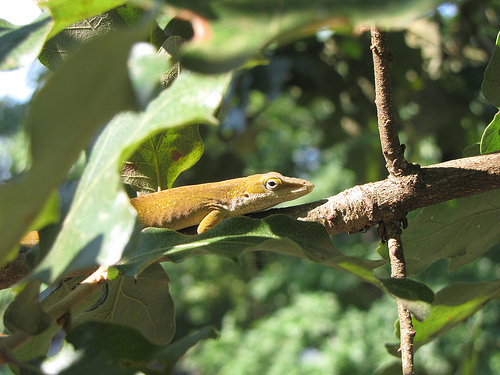

In [11]:
image

In [12]:
output = model(input_tensor)
pred_class = torch.argmax(output, dim=1).item()
print(f"Classe prédite: {pred_class}")
probs = torch.nn.functional.softmax(output, dim=1)
print(f"Probabilités: {probs[0, pred_class]}")

Classe prédite: 40
Probabilités: 0.7104200124740601


In [13]:
def list_files(directory, extension:str=".npz"):
    """Liste tous les fichiers .npz dans le dossier spécifié."""
    return [f for f in os.listdir(directory) if f.endswith(extension)]

# Exemple d'utilisation
directory = "./data/heatmap"  # Remplacez par votre chemin
files = list_files(directory, extension=".npz")
print(files)

['n01443537_130.npz', 'n01484850_198.npz', 'n01494475_20.npz', 'n01622779_172.npz', 'n01829413_46.npz', 'n01843383_547.npz', 'n02071294_4132.npz', 'n02071294_4408.npz', 'n02391049_544.npz', 'n02437312_845.npz', 'n02480495_162.npz']


In [14]:
GMM_CONST = "GMM"
KMEANS_CONST = "KMeans"
SPECTRAL_CONST = "SpectralClustering"
AGGLOMERATIVE_CONST = "AgglomerativeClustering"

In [15]:
methods = {
    GMM_CONST: lambda n: GaussianMixture(n_components=n, random_state=42, covariance_type='diag', reg_covar=1e-3),
    KMEANS_CONST: lambda n: KMeans(n_clusters=n, random_state=42),
    SPECTRAL_CONST: lambda n: SpectralClustering(n_clusters=n, affinity='nearest_neighbors', random_state=42),
    AGGLOMERATIVE_CONST: lambda n: AgglomerativeClustering(n_clusters=n),
}

In [48]:
def load_and_process(file_name : str,
                     layer_name : str = "layer_40"):
    data = np.load(f"data/heatmap/{file_name}")
    heatmaps = data[layer_name]
    heatmaps = np.abs(heatmaps)
    heatmaps_flat = heatmaps.reshape(heatmaps.shape[0], -1)

    scaler = StandardScaler()
    heatmaps_scaled = scaler.fit_transform(heatmaps_flat)
    return heatmaps, heatmaps_scaled

In [17]:
def analysis_clusters(methods_cluster,
                      heatmaps_scaled,
                      picture_name,
                      min_cluster : int = 2,
                      max_cluster : int = 16):
    cluster_range = range(min_cluster, max_cluster)
    silhouette_scores = {method: [] for method in methods}
    GMM_dict = {}
    KMeans_dict = {}
    Spectral_dict = {}
    Agglomerative_dict = {}

    for n_clusters in cluster_range:
        print(f"Cluster numéro {n_clusters}")
        for method_name, clustering_function in methods_cluster.items():
            print(f"Analyse de {method_name}")
            model = clustering_function(n_clusters)
            labels = model.fit_predict(heatmaps_scaled)

            if len(set(labels)) > 1:
                score = silhouette_score(heatmaps_scaled, labels)
            else:
                score = -1
            silhouette_scores[method_name].append(score)

            if method_name == GMM_CONST:
                GMM_dict[n_clusters] = labels
            elif method_name == KMEANS_CONST:
                KMeans_dict[n_clusters] = labels
            elif method_name == SPECTRAL_CONST:
                Spectral_dict[n_clusters] = labels
            elif method_name == AGGLOMERATIVE_CONST:
                Agglomerative_dict[n_clusters] = labels

    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
    labels_hdbscan = hdbscan_clusterer.fit_predict(heatmaps_scaled)
    hdbscan_score = silhouette_score(heatmaps_scaled, labels_hdbscan) if len(set(labels_hdbscan)) > 1 else -1
    silhouette_scores["HDBSCAN"] = [hdbscan_score] * len(cluster_range)

    general_dict = {}
    list_dict_keys = list(GMM_dict.keys())
    for key in list_dict_keys:
        general_dict[f"{key}_{GMM_CONST}"] = np.array(GMM_dict[key])
        general_dict[f"{key}_{KMEANS_CONST}"] = np.array(KMeans_dict[key])
        general_dict[f"{key}_{SPECTRAL_CONST}"] = np.array(Spectral_dict[key])
        general_dict[f"{key}_{AGGLOMERATIVE_CONST}"] = np.array(Agglomerative_dict[key])

    np.savez(f"./data/clusters/clusters_{picture_name}.npz", **general_dict)
    return silhouette_scores, cluster_range

In [18]:
def analysis_on_all_picture(list_files_name : list) :
    num_files = len(list_files_name)
    fig, axes = plt.subplots(1, num_files, figsize=(10 * num_files, 6))

    if num_files == 0:
        return

    if num_files == 1:
        axes = [axes]

    for ax, file_name in zip(axes, list_files_name):
        print(f"Analyse de {file_name}")
        _, heatmaps_scaled = load_and_process(file_name, layer_name="layer_40")
        silhouette_scores, cluster_range = analysis_clusters(methods, heatmaps_scaled, file_name)

        for method, scores in silhouette_scores.items():
            ax.plot(cluster_range, scores, marker='o', linestyle='-', label=method)

        ax.set_xlabel("Nombre de Clusters")
        ax.set_ylabel("Silhouette Score")
        ax.set_title(f"Comparaison des Algorithmes de Clustering\n{file_name}")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Trouver le meilleur clustering
    best_methods = {method: cluster_range[np.argmax(scores)] for method, scores in silhouette_scores.items()}
    print("Meilleur nombre de clusters par méthode :", best_methods)

Analyse de n01443537_130.npz
Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans


D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Analyse de n01484850_198.npz
Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans


D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Analyse de n01494475_20.npz
Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans
A

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Analyse de n01622779_172.npz
Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans


D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Analyse de n01829413_46.npz
Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans
A

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Analyse de n01843383_547.npz
Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans


D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Analyse de n02071294_4132.npz
Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Analyse de n02071294_4408.npz
Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Analyse de n02391049_544.npz
Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans


D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Analyse de n02437312_845.npz
Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans


D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Analyse de n02480495_162.npz
Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans


D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


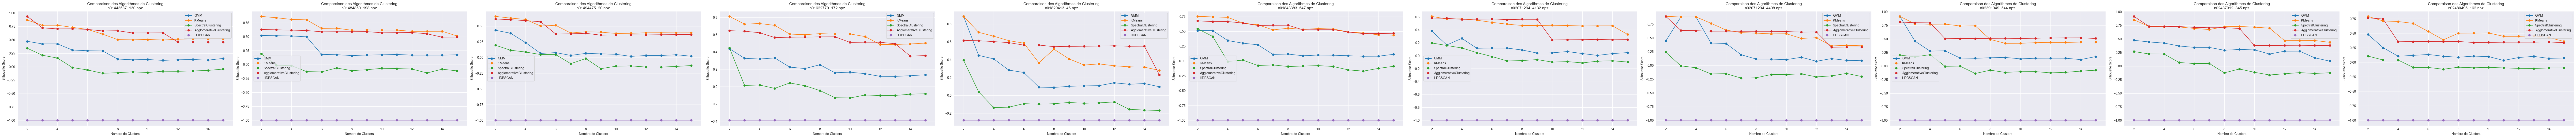

Meilleur nombre de clusters par méthode : {'GMM': 2, 'KMeans': 2, 'SpectralClustering': 2, 'AgglomerativeClustering': 2, 'HDBSCAN': 2}


In [22]:
analysis_on_all_picture(files)

In [21]:
directory_clusters = "./data/clusters"  # Remplacez par votre chemin
files_clusters = list_files(directory_clusters, extension=".npz")
print(files_clusters)

['clusters_n01443537_130.npz.npz', 'clusters_n01484850_198.npz.npz', 'clusters_n01494475_20.npz.npz', 'clusters_n01622779_172.npz.npz', 'clusters_n01829413_46.npz.npz', 'clusters_n01843383_547.npz.npz', 'clusters_n02071294_4132.npz.npz', 'clusters_n02071294_4408.npz.npz', 'clusters_n02391049_544.npz.npz', 'clusters_n02437312_845.npz.npz', 'clusters_n02480495_162.npz.npz']


In [22]:
chosen_cluster_file_name = files_clusters[0]

In [24]:
def extract_picture_name(file_name):
    """Extrait picture_name d'un nom de fichier formaté comme clusters_{picture_name}.npz."""
    match = re.match(r"clusters_(.+)\.npz", file_name)
    return match.group(1) if match else None

In [27]:
def extract_code(filename: str) -> str:
    match = re.match(r"(n\d+)_", filename)
    return match.group(1) if match else ""

In [37]:
picture_name = extract_picture_name(chosen_cluster_file_name)
picture_name_with_extension = f"{picture_name}.npz"

In [28]:
class_name = extract_code(picture_name)

In [32]:
import json

def inverse_json(json_path, output_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    inverted = {values[0]: values[1] for values in data.values()}

    with open(output_path, 'w') as outfile:
        json.dump(inverted, outfile, indent=4)

    return inverted

# Exemple d'utilisation
json_path = 'data/imagenet_class_index.json'
output_path = 'data/imagenet_class_index_reversed.json'
inverted_dict = inverse_json(json_path, output_path)

In [33]:
with open("data/imagenet_class_index_reversed.json", "r") as file:
    class_index = json.load(file)

In [35]:
print(class_name)
print(class_index[class_name])

n01443537
goldfish


In [23]:
data = np.load(f"data/clusters/{chosen_cluster_file_name}")
cluster_label = data[f"{6}_{KMEANS_CONST}"]

In [38]:
heatmaps, heatmaps_scaled = load_and_process(picture_name, layer_name="layer_40")

In [59]:
heatmaps_by_cluster = {}

for cluster in set(cluster_label):
    if cluster == -1:
        continue

    indices = np.where(cluster_label == cluster)[0]

    heatmaps_by_cluster[cluster] = heatmaps[indices]

for cluster, heatmaps_clusters in heatmaps_by_cluster.items():
    print(f"Cluster {cluster} : {heatmaps_clusters.shape[0]} éléments")

Cluster 0 : 6 éléments
Cluster 1 : 34 éléments
Cluster 2 : 1 éléments
Cluster 3 : 1 éléments
Cluster 4 : 464 éléments
Cluster 5 : 6 éléments


Cluster 0 : 6 éléments


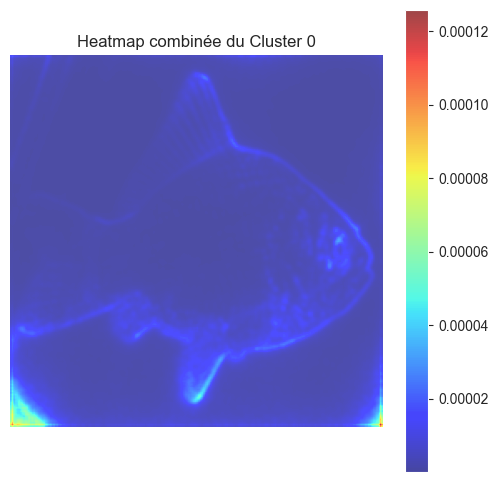

Cluster 1 : 34 éléments


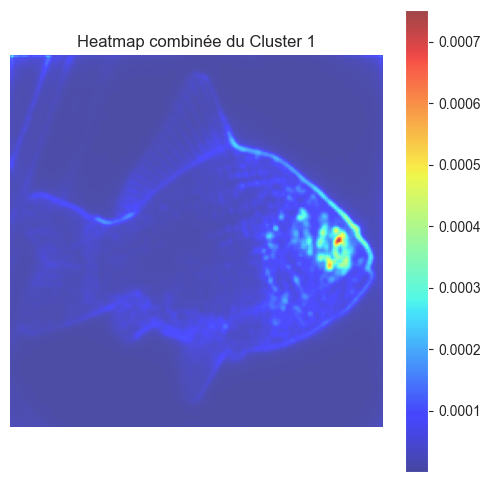

Cluster 2 : 1 éléments


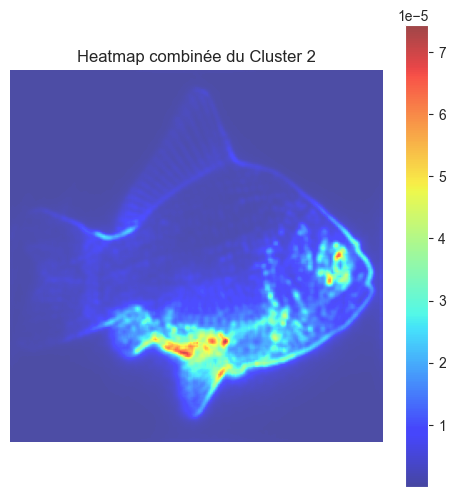

Cluster 3 : 1 éléments


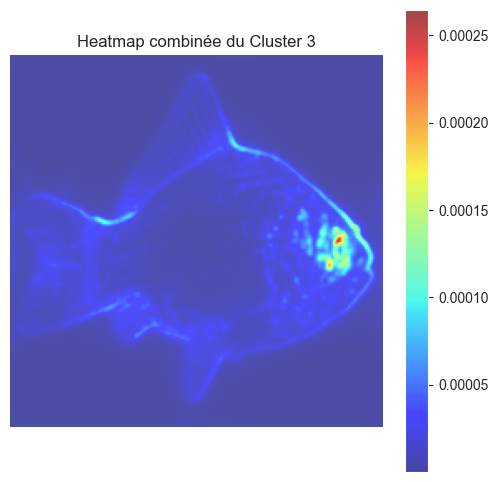

Cluster 4 : 464 éléments


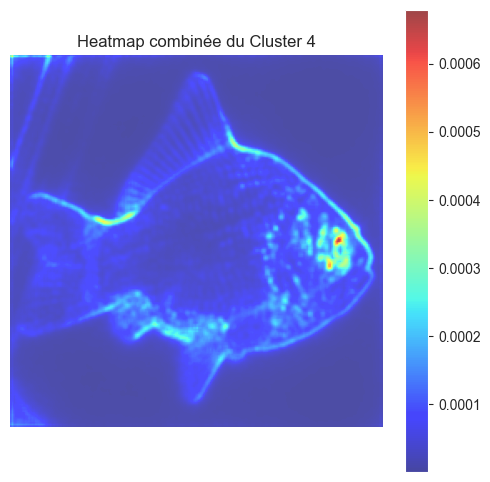

Cluster 5 : 6 éléments


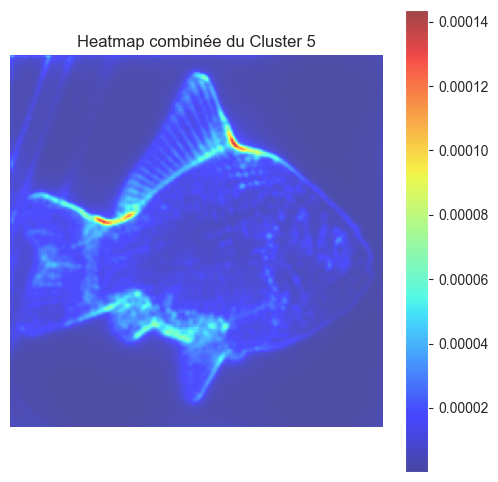

In [60]:
for cluster, heatmaps in heatmaps_by_cluster.items():
    if heatmaps.shape[0] == 0:
        continue

    combined_heatmap = np.sum(heatmaps, axis=0)

    print(f"Cluster {cluster} : {heatmaps.shape[0]} éléments")
    plt.figure(figsize=(6, 6))
    plt.imshow(combined_heatmap, cmap="jet", alpha=0.7)
    plt.axis("off")
    plt.colorbar()
    plt.title(f"Heatmap combinée du Cluster {cluster}")
    plt.show()

In [57]:
def visualize_clusters(data, min_cluster, max_cluster, methods, picture_name):
    num_methods = len(methods)
    num_clusters = max_cluster - min_cluster + 1

    for cluster_idx, cluster_num in enumerate(range(min_cluster, max_cluster + 1)):
        fig, axes = plt.subplots(nrows=num_methods, ncols=max(4,(cluster_idx + min_cluster + 1)), figsize=(16, 4 * num_methods))
        heatmaps_by_method = {}

        for method in methods:
            cluster_label = data[f"{cluster_num}_{method}"]
            heatmaps, _ = load_and_process(picture_name, layer_name="layer_40")
            heatmaps_by_cluster = {}

            for cluster in set(cluster_label):
                if cluster == -1:
                    continue
                indices = np.where(cluster_label == cluster)[0]
                heatmaps_by_cluster[cluster] = heatmaps[indices]

            heatmaps_by_method[method] = heatmaps_by_cluster

        for method_idx, method in enumerate(methods):
            heatmaps_by_cluster = heatmaps_by_method[method]

            for cluster, heatmaps in heatmaps_by_cluster.items():
                if heatmaps.shape[0] == 0:
                    continue
                combined_heatmap = np.sum(heatmaps, axis=0)

                ax = axes[method_idx, cluster] if num_methods > 1 else axes[cluster]
                ax.imshow(combined_heatmap, cmap="jet", alpha=0.7)
                ax.axis("off")
                ax.set_title(f"Cluster {cluster}\n{method}")

        plt.tight_layout()
        plt.show()


In [67]:
def visualize_clusters(data, min_cluster, max_cluster, methods, picture_name):
    num_methods = len(methods)
    num_clusters = max_cluster - min_cluster + 1

    for cluster_idx, cluster_num in enumerate(range(min_cluster, max_cluster + 1)):
        fig, axes = plt.subplots(nrows=num_methods, ncols=max(4, cluster_idx + min_cluster), figsize=(16, 4 * num_methods))
        heatmaps_by_method = {}
        vmin, vmax = float("inf"), float("-inf")

        for method in methods:
            cluster_label = data[f"{cluster_num}_{method}"]
            heatmaps, _ = load_and_process(picture_name, layer_name="layer_40")
            heatmaps_by_cluster = {}

            for cluster in set(cluster_label):
                if cluster == -1:
                    continue
                indices = np.where(cluster_label == cluster)[0]
                cluster_heatmaps = heatmaps[indices]
                heatmaps_by_cluster[cluster] = cluster_heatmaps

                if cluster_heatmaps.shape[0] > 0:
                    combined_heatmap = np.sum(cluster_heatmaps, axis=0)
                    vmin = min(vmin, combined_heatmap.min())
                    vmax = max(vmax, combined_heatmap.max())

            heatmaps_by_method[method] = heatmaps_by_cluster

        for method_idx, method in enumerate(methods):
            heatmaps_by_cluster = heatmaps_by_method[method]

            for cluster, heatmaps in heatmaps_by_cluster.items():
                if heatmaps.shape[0] == 0:
                    continue
                combined_heatmap = np.sum(heatmaps, axis=0)

                ax = axes[method_idx, cluster] if num_methods > 1 else axes[cluster]
                im = ax.imshow(combined_heatmap, cmap="jet", alpha=0.7, vmin=vmin, vmax=vmax)
                ax.axis("off")
                ax.set_title(f"Cluster {cluster}\n{method}\n{heatmaps.shape[0]} éléments")

            # Ajouter la barre des couleurs dans la dernière colonne
            cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position relative de la colorbar
            fig.colorbar(im, cax=cax)

        #plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ajustement pour laisser de la place à la colorbar
        plt.show()

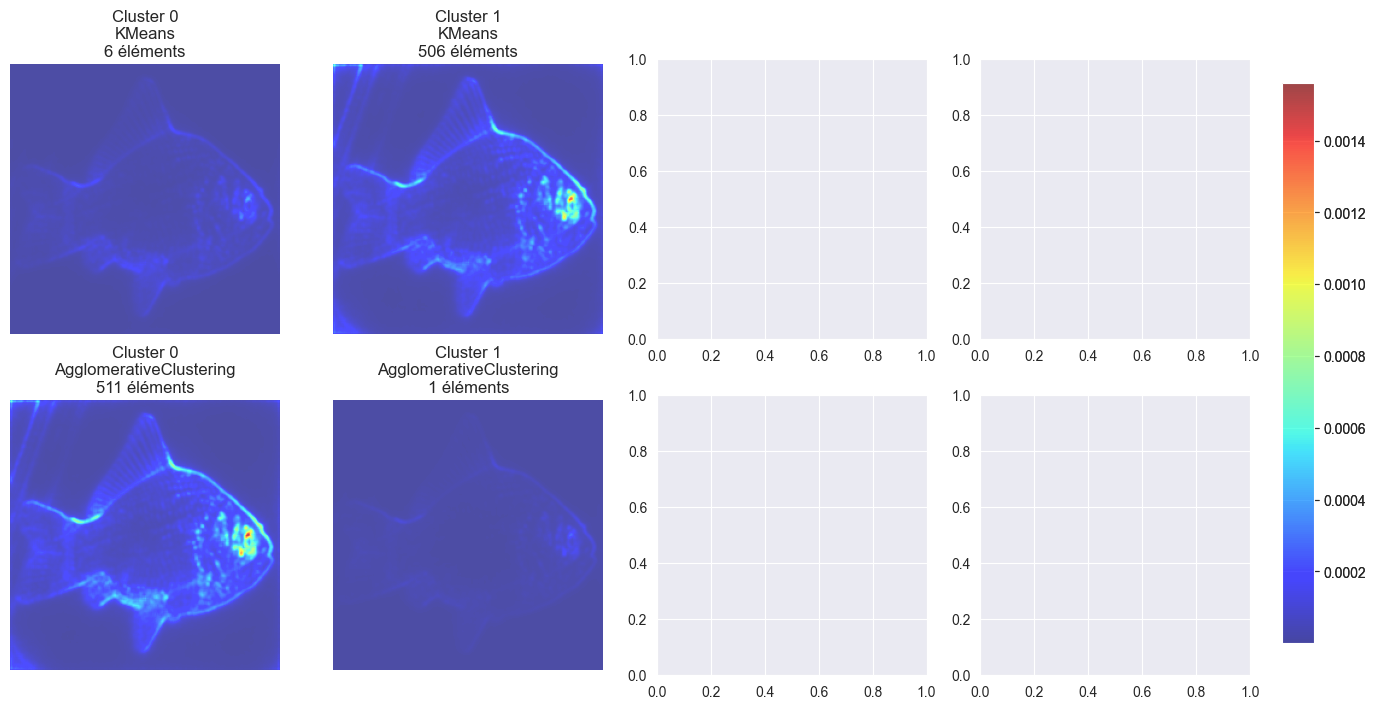

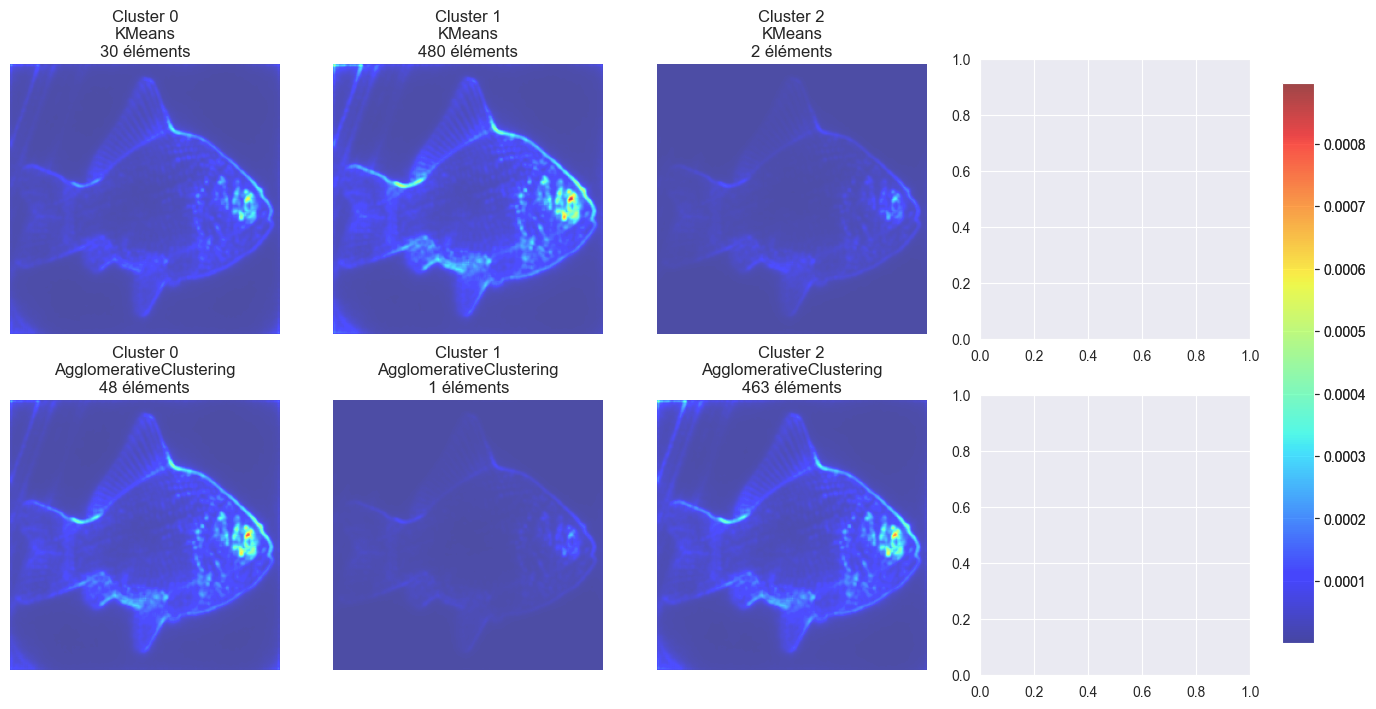

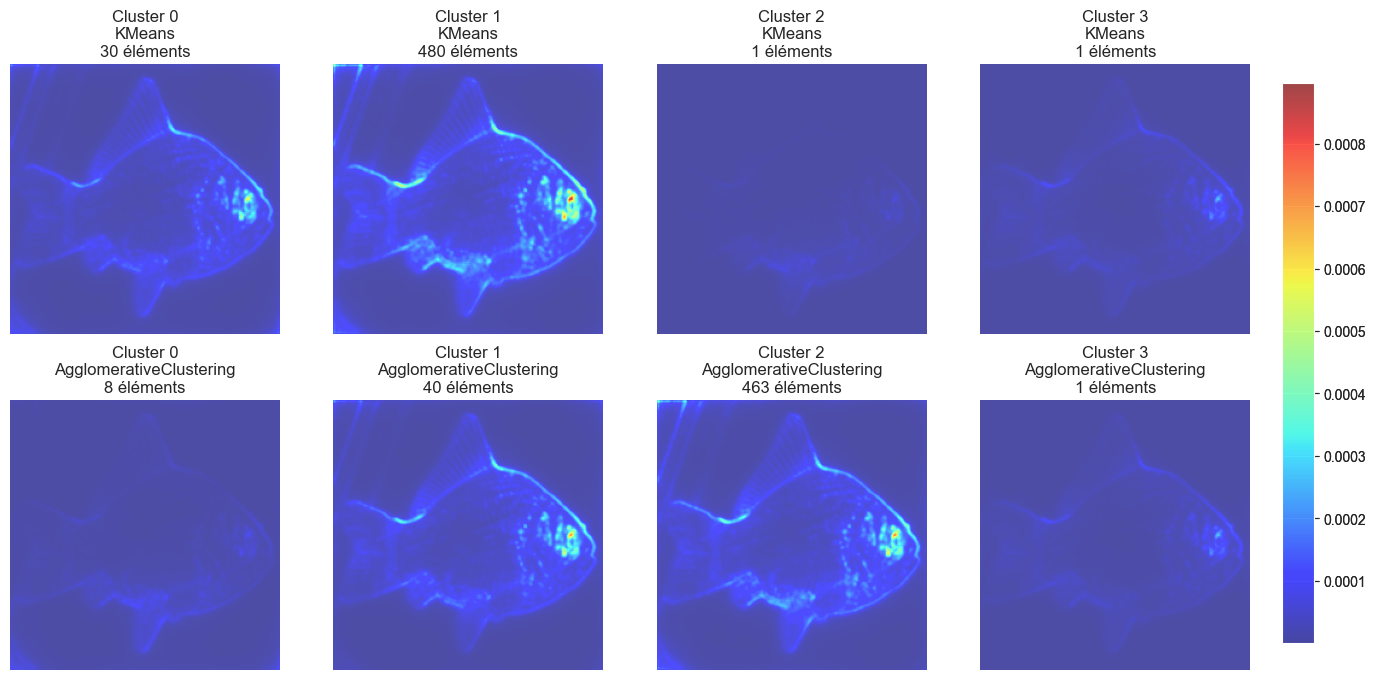

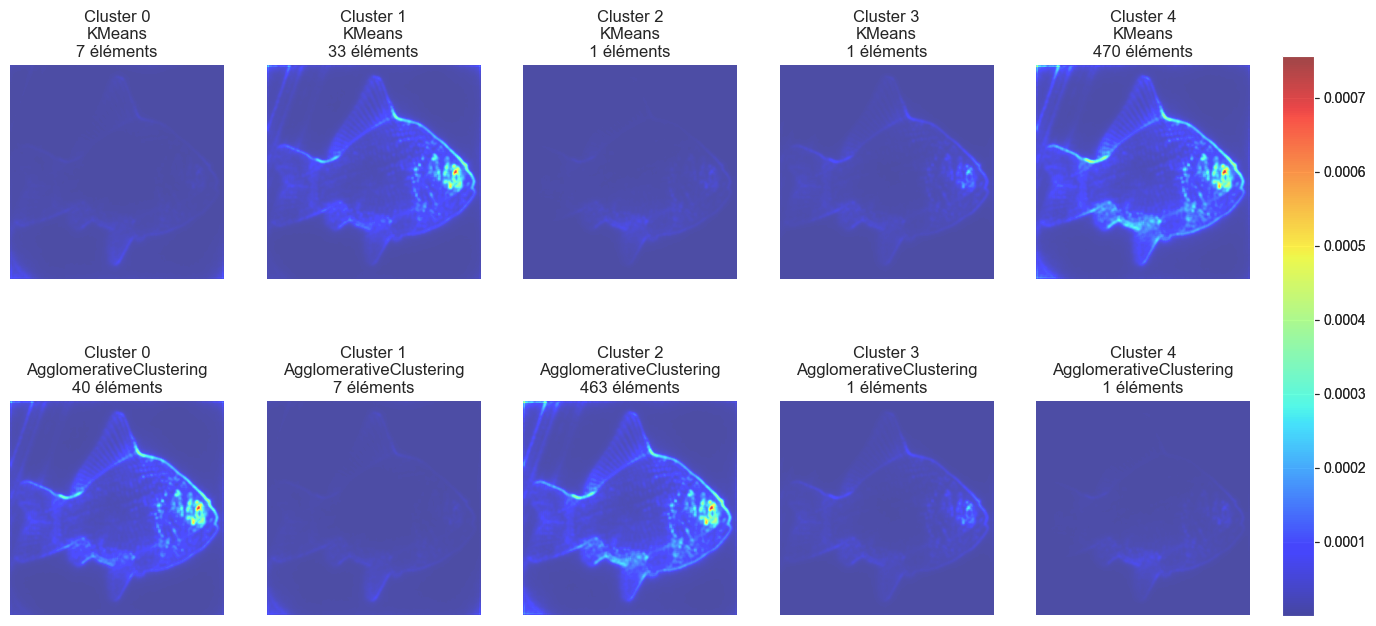

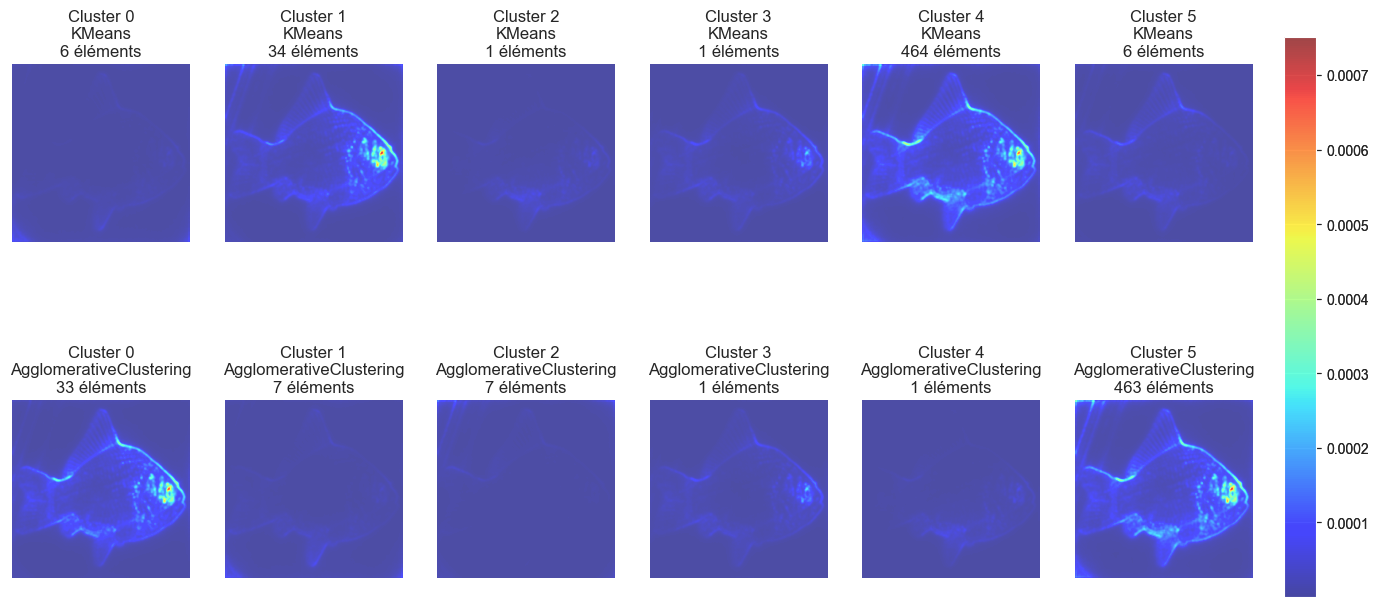

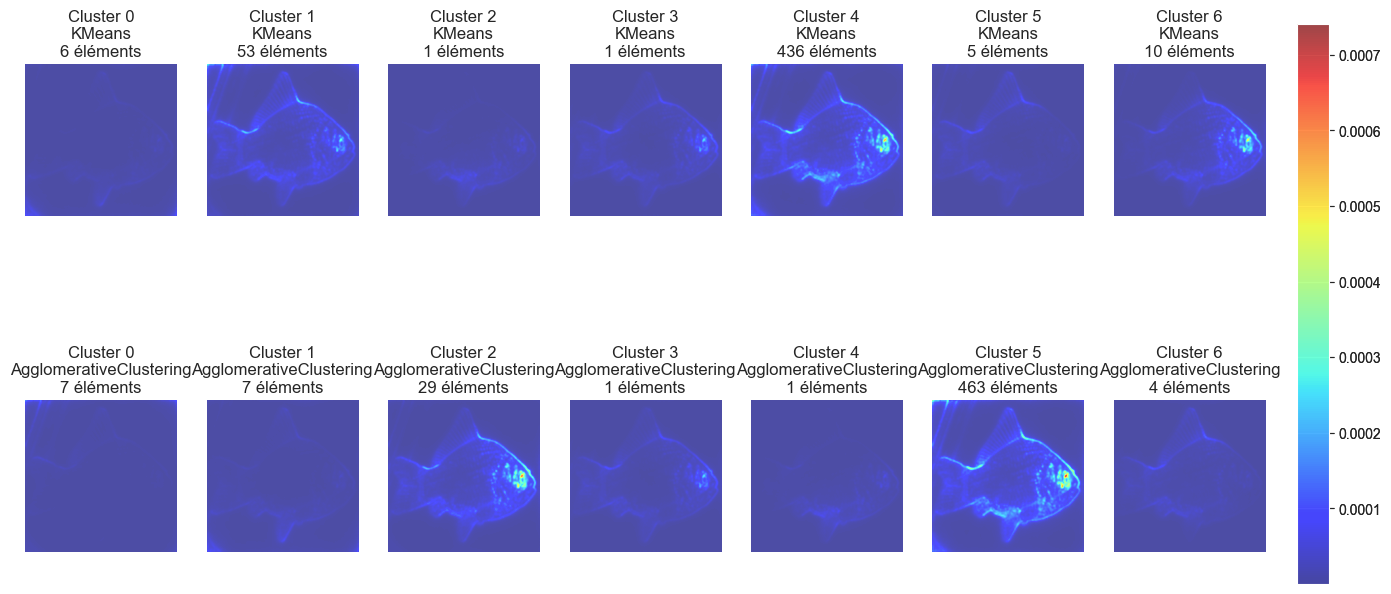

In [68]:
visualize_clusters(data, 2, 7, [KMEANS_CONST, AGGLOMERATIVE_CONST], picture_name)